In [374]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import kagglehub
import re


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [375]:
# Data Analyst Jobs dataset
path = kagglehub.dataset_download("andrewmvd/data-analyst-jobs")
print("Path to dataset files:", path)
df = pd.read_csv(path + '/DataAnalyst.csv')

Path to dataset files: C:\Users\sara\.cache\kagglehub\datasets\andrewmvd\data-analyst-jobs\versions\1


## 2. Preprocessing

Primer eliminarem la variable Unnamed perquè és un identificador que resulta redundant, ja que Python ja assigna un índex a cada dada del dataset.

In [376]:
df.drop(columns=["Unnamed: 0"], inplace=True)

A continuació convertirem les variables categòriques a numèriques tractant alhora tots els nans

**Salary Estimate**

In [377]:
def check_missing(attribute):
    mask_missing = (
        df[attribute].isna() |
        (df[attribute] == -1) |
        (df[attribute] == "-1") |
        (df[attribute] == "Unknown") |
        (df[attribute] == "Unknown / Non-Applicable")
    )

    # Obtener índices (IDs de fila)
    missing_indices = df[mask_missing].index.tolist()

    print("Total missing values:", len(missing_indices))
    return missing_indices


In [378]:
missing_indices = check_missing("Salary Estimate")
print("IDs de les filas amb missing:")
print(missing_indices)

Total missing values: 1
IDs de les filas amb missing:
[2149]


Hi ha un sol nul a cada columna, que es dona perquè no hi ha un interval a aquella dada. Concretament, aquell sou te el valor -1, per tant, és un error. Com Salary Estimate és la variable que volem predir, no té sentit imputar aquest valor, per tant eliminem aquesta fila del dataset.

In [379]:
df.drop(index=missing_indices, inplace=True)
df.reset_index(drop=True, inplace=True)

In [380]:
missing_indices = check_missing("Salary Estimate")

Total missing values: 0


In [381]:
def clean_salary(text):
    # Extrae todos los números del texto, en miles (K)
    numbers = re.findall(r'(\d+)', text)
    
    if len(numbers) >= 2:
        low = int(numbers[0])
        high = int(numbers[1])
        avg = (low + high)/2
        return low, high, avg
    else:
        return None, None, None
  
df["min_salary"], df["max_salary"], df["avg_salary"] = zip(*df["Salary Estimate"].apply(clean_salary))
df[["min_salary", "max_salary", "avg_salary"]].head()

,min_salary,max_salary,avg_salary
0,37,66,51.5
1,37,66,51.5
2,37,66,51.5
3,37,66,51.5
4,37,66,51.5


In [382]:
check_missing("avg_salary")
check_missing("min_salary")
check_missing("max_salary")

Total missing values: 0
Total missing values: 0
Total missing values: 0


[]

<Axes: >

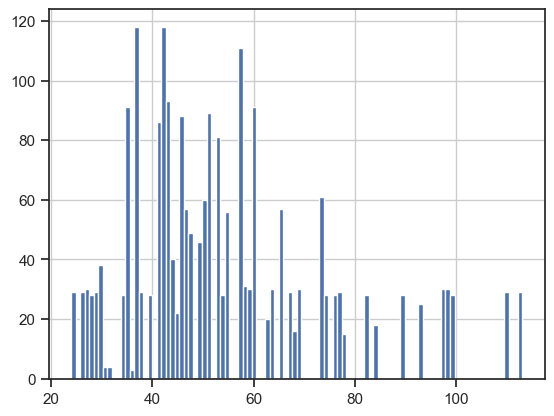

In [383]:
df['min_salary'].hist(bins=100)

<Axes: >

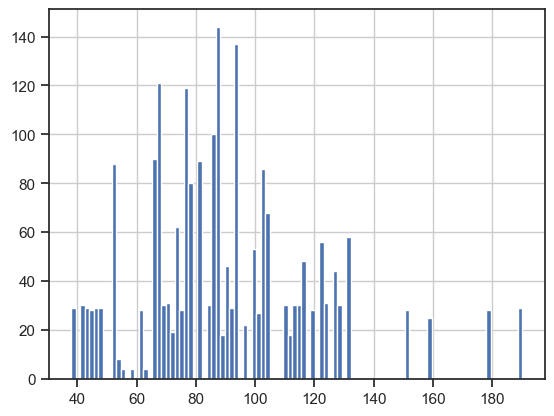

In [384]:
df['max_salary'].hist(bins=100)

**Size**

Les dades estan en la forma "201 to 500 employees" o "100000+ employees". Les convertim a un nombre mig si es troba en un rang de valors.

In [385]:
def parse_size(size):
    if size in [None, '-1', 'Unknown / Non-Applicable']:
        # Posem null si no es coneix la mida
        return None 
    if '+' in size:
        return float(size.replace('+ employees', '').strip())
    if 'to' in size:
        low, high = size.replace('employees', '').split('to')
        return int((float(low) + float(high)) / 2)
    return None

df['Size mean'] = df['Size'].apply(parse_size)
df['Size mean']

0         350.0
1       10000.0
2        3000.0
3         350.0
4         750.0
         ...   
2247      125.0
2248    10000.0
2249        NaN
2250      350.0
2251    10000.0
Name: Size mean, Length: 2252, dtype: float64

In [386]:
missing_indices = check_missing("Size mean")
percentatge_missing = len(missing_indices) / len(df) * 100
print("Percentatge de missing:", percentatge_missing, "%")

Total missing values: 205
Percentatge de missing: 9.103019538188278 %


In [387]:
df['Size mean'] = df['Size mean'].fillna(df['Size mean'].median())


In [388]:
check_missing("Size mean")

Total missing values: 0


[]

**Revenue**

Les dades apareixen en la forma: "$100 to $500 million (USD)". Les convertim en un valor mig.

In [389]:
def parse_revenue(rev):
        if rev in ['Unknown / Non-Applicable', '-1', None]:
            return None
        
        rev = rev.replace('(USD)', '').replace('$', '').strip()

        # Caso "X to Y million" o "billion"
        if 'to' in rev:
            low, high = rev.split('to')
            low = low.strip()
            high = high.strip()

            # Identificar unidad
            if 'million' in high:
                mul = 1_000_000
            elif 'billion' in high:
                mul = 1_000_000_000
            else:
                return None

            low_val = float(low.replace('million', '').replace('billion', '').strip()) * mul
            high_val = float(high.replace('million', '').replace('billion', '').strip()) * mul

            return (low_val + high_val) / 2
        
        return None

df['Revenue mean'] = df['Revenue'].apply(parse_revenue)
df['Revenue mean']

0       3.000000e+08
1       3.500000e+09
2                NaN
3       7.500000e+07
4       3.000000e+08
            ...     
2247             NaN
2248             NaN
2249             NaN
2250    3.750000e+07
2251    3.500000e+09
Name: Revenue mean, Length: 2252, dtype: float64

In [390]:
missing_indices = check_missing("Revenue mean")
percentatge_missing = len(missing_indices) / len(df) * 100
print("Percentatge de missing:", percentatge_missing, "%")

Total missing values: 1060
Percentatge de missing: 47.06927175843694 %


In [391]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Calcular matriu de correlació
corr_matrix = numeric_df.corr()

# Correlacions específiques amb Revenue mean
corr_with_rev = corr_matrix['Revenue mean'].sort_values(ascending=False)

print("Correlació amb Revenue mean")
print(corr_with_rev)

Correlació amb Revenue mean
Revenue mean    1.000000
Size mean       0.140264
Founded         0.073430
max_salary     -0.011609
avg_salary     -0.019458
min_salary     -0.029965
Rating         -0.055568
Name: Revenue mean, dtype: float64


Quan una variable té tants NaNs, el seu valor informatiu és molt baix, però el fet que no hi hagi informació potser és informatiu en si mateix. Moltes empreses petites no publiquen el seu revenue, mentre que les grans sí. Això es veu a les correlacions, ja que encara que és poca, la correlació més forta amb Revenue és el Size de l'empresa.

Per tant, aquesta columna no s’ha d’imputar amb la mediana, perquè hi ha massa NaNs i imputar amb la mateixa mediana els faria semblants a les grans empreses.

Crearem feature booleana per veure si l'empresa dona informació pel revenue. I imputarem els nans amb valor neutre 0

In [392]:
df['Has_revenue_info'] = df['Revenue mean'].notna().astype(int)
df['Revenue mean'] = df['Revenue mean'].fillna(0)
df['Revenue mean'].isna().sum()

np.int64(0)

**Founded**

Transformar l'any de fundacio de l'empresa en "l'edat" que té l'empresa. Empreses més establertes solen pagar més i tenir salaris més estables

Si no sabem l'any de fundació, el valor serà NULL. 

In [393]:
df['Company Age'] = df['Founded'].apply(lambda x: 2025 - x if (pd.notna(x) and x != -1) else None)
df[["Company Age"]]

,Company Age
0,64.0
1,132.0
2,22.0
3,23.0
4,16.0
...,...
2247,NaN
2248,90.0
2249,NaN
2250,41.0


Per tractar els nuls, primer omplim aquelles company age conegudes per altres entrada del dataset que siguin de la mateixa companyia.

In [394]:
df['Company Age'] = df.groupby('Company Name')['Company Age'].transform(
    lambda col: col.fillna(col.dropna().median()) if col.notna().any() else col)

In [395]:
missing_indices = check_missing("Company Age")
percentatge_missing = len(missing_indices) / len(df) * 100
print("Percentatge de missing:", percentatge_missing, "%")

Total missing values: 658
Percentatge de missing: 29.218472468916517 %


Busquem correlacio de company age amb les altres variables del dataset i mirem si podem imputar els nans faltants amb la mitjana del seu grup

In [396]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Calcular matriu de correlació
corr_matrix = numeric_df.corr()

# Correlacions específiques amb Company Age
corr_with_age = corr_matrix['Company Age'].sort_values(ascending=False)

print("Correlació amb Company Age")
print(corr_with_age)

Correlació amb Company Age
Company Age         1.000000
Size mean           0.581066
Revenue mean       -0.010476
min_salary         -0.082532
Rating             -0.082620
avg_salary         -0.095542
max_salary         -0.098823
Has_revenue_info   -0.153060
Founded            -0.541453
Name: Company Age, dtype: float64


Veiem que la relació més forta és amb el tamany de l'empresa, per tant fem servir aquesta variable per omplir els valors que falten

<Figure size 1000x600 with 0 Axes>

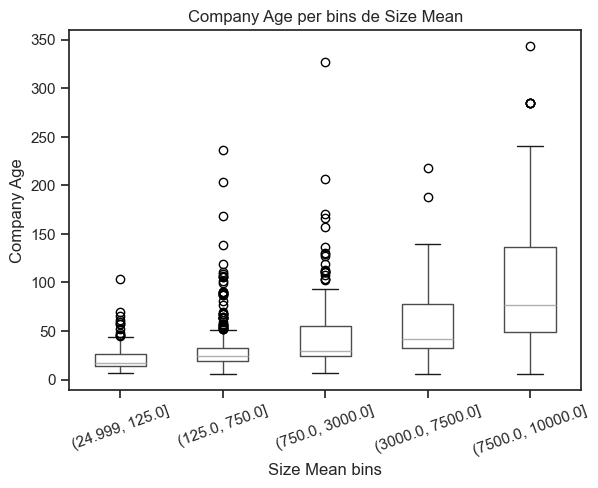

In [397]:
# Crear bins automàtics per Size mean
df['Size Bin'] = pd.qcut(df['Size mean'], q=6, duplicates='drop')

plt.figure(figsize=(10, 6))
df.boxplot(column='Company Age', by='Size Bin', grid=False)
plt.title("Company Age per bins de Size Mean")
plt.suptitle("")
plt.xlabel("Size Mean bins")
plt.ylabel("Company Age")
plt.xticks(rotation=20)
plt.show()


Podem observar com existeix clara relació entre les empreses grans (dentre 3000 i 10000 empleats) i l'edat mitjana, que és més alta que per les empreses petites. 

Observem que hi ha certa dispersió però les medianes es veuen com són progressives entre tots els quantils de manera que els outliers que observem no afecten gaire a la mitjana. Per tant, fearem servir la mitjana per imputar.

In [398]:
# Mediana d'edat per bin
median_age_by_bin = df.groupby('Size Bin', observed=True)['Company Age'].median()

# Funció d'imputació
def impute_age_by_bin(row):
    if pd.isna(row['Company Age']):
        return median_age_by_bin[row['Size Bin']]
    return row['Company Age']

# Aplicar imputació
df['Company Age'] = df.apply(impute_age_by_bin, axis=1)

# Eliminar columna auxiliar
df.drop(columns=['Size Bin'], inplace=True)


In [399]:
missing_indices = check_missing("Company Age")

Total missing values: 0


Ara eliminem les variables categòriques d'abans de la conversió.

In [400]:
df.drop(columns=["Salary Estimate", "Revenue", "Size", "Founded"], inplace=True)

**Rating**

In [401]:
missing_indices = check_missing("Rating")
percentatge_missing = len(missing_indices) / len(df) * 100
print("Percentatge de missing:", percentatge_missing, "%")

Total missing values: 272
Percentatge de missing: 12.078152753108348 %


In [402]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Calcular matriu de correlació
corr_matrix = numeric_df.corr()

# Correlacions específiques amb Rating
corr_with_rating = corr_matrix['Rating'].sort_values(ascending=False)

print("Correlació amb Rating")
print(corr_with_rating)

Correlació amb Rating
Rating              1.000000
Has_revenue_info    0.334734
Size mean           0.148714
Company Age         0.094040
Revenue mean        0.044656
max_salary          0.012157
avg_salary          0.004301
min_salary         -0.007836
Name: Rating, dtype: float64


La relacio més forta és amb Has_revenue_info, però no és suficientment forta. Per imputar els valors nuls, farem servir un model senzill de Random Forest.

In [403]:
df['Rating'] = df['Rating'].replace(-1, np.nan)
dfnum = df[['min_salary', 'max_salary', 'Rating', 'Company Age']]

train = dfnum[dfnum['Rating'].notna()]
test = dfnum[dfnum['Rating'].isna()]

X_train = train.drop('Rating', axis=1)
y_train = train['Rating']
X_test = test.drop('Rating', axis=1)

# Entrenem model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predecim els nuls
df.loc[df['Rating'].isna(), 'Rating'] = model.predict(X_test)


<Axes: >

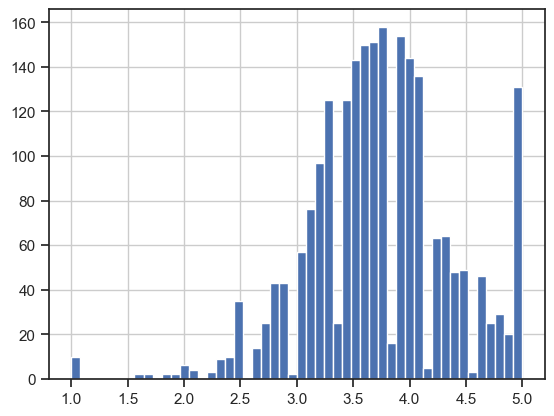

In [404]:
df['Rating'].hist(bins=50)

**Comparem les variables numèriques entre elles**

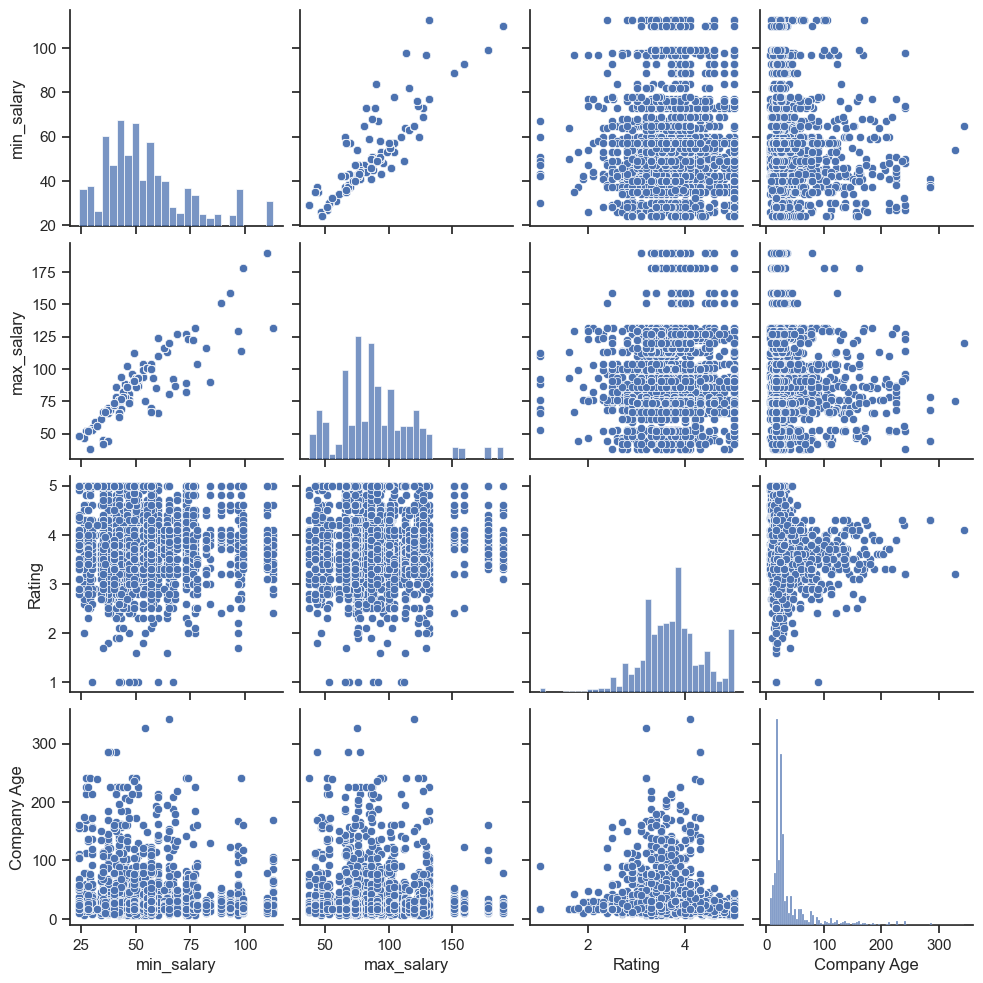

In [405]:
num_variables = ['min_salary', 'max_salary', 'Rating', 'Company Age']

sns.set_theme(style="ticks")

sns.pairplot(df[num_variables])

**Selecció de variables**

Un cop tranformat el Sou estimat a numèric, analitzer les correlacions de les dades. El dataset té molts atributs categòrics que tenen molts valors, per tant, seria util podre fer selecció de variables en aquest punt basant-nos en la relació que tenen amb el sou.

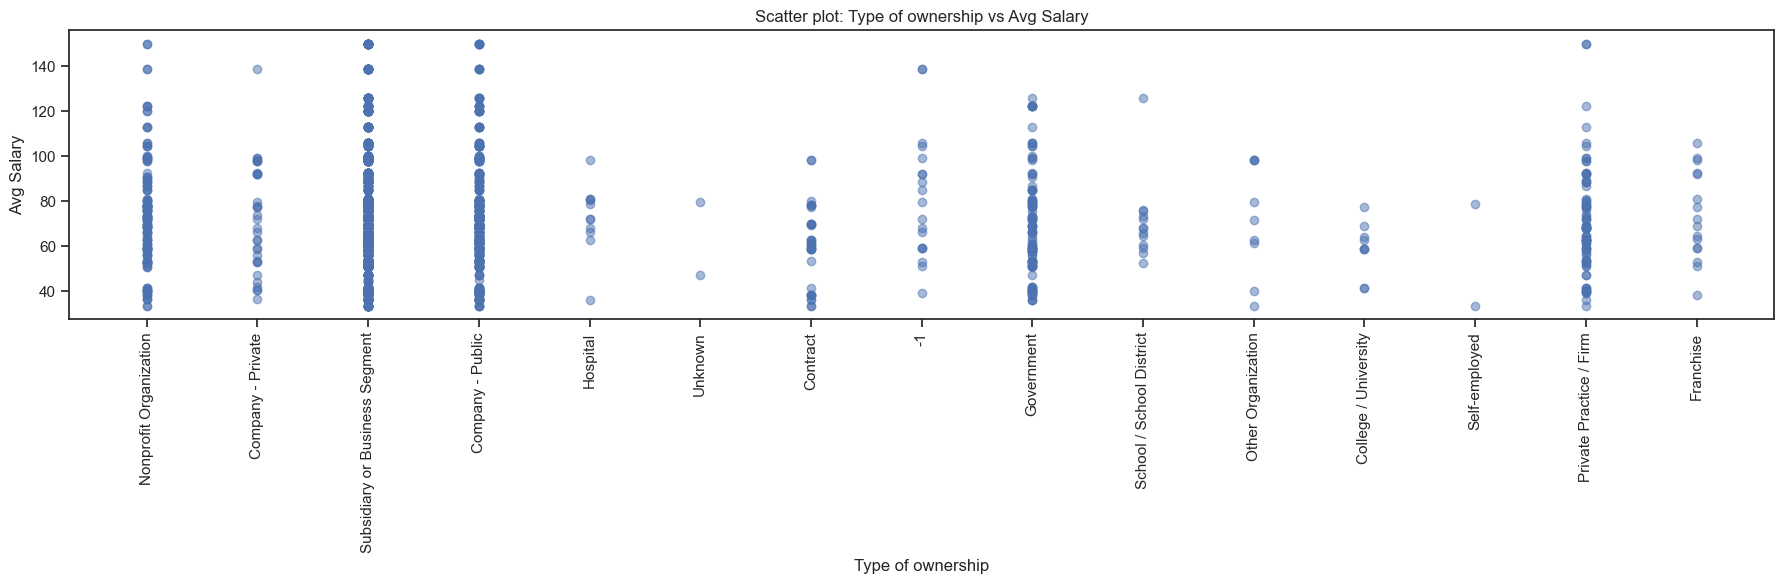

In [406]:
plt.figure(figsize=(18, 6))

# Codificar sectores numéricamente solo para poder graficar
df["Type of ownership code"] = df["Type of ownership"].astype("category").cat.codes

plt.scatter(df["Type of ownership code"], df["avg_salary"], alpha=0.5)

plt.xticks(
    ticks=range(len(df["Type of ownership"].unique())), 
    labels=df["Type of ownership"].unique(), 
    rotation=90
)

plt.title("Scatter plot: Type of ownership vs Avg Salary")
plt.xlabel("Type of ownership")
plt.ylabel("Avg Salary")
plt.tight_layout()
plt.show()


A primera vista, no podem establir si el Type of Ownership és una variable que afecta al sou. Hi ha tipus que tenen molta variabilitat del sou i altres que tenen variabilitat més baixa i sous també més baixos.

Per veure numèricament si el Type of Ownership afecta al sou mig (avg_salary), fem un ANOVA per comprovar si hi ha diferències significatives entre sectors i calculem el R² per mesurar quina part de la variabilitat salarial s’explica pel tipus d'empresa.

El ANOVA (Anàlisi de la Variança) serveix per comprovar si hi ha diferències estadísticament significatives entre els salaris mitjans dels sectors. El p-value ens indica si podem rebutjar la hipòtesi nul·la que afirma que tots els sectors tenen el mateix salari mitjà. Per poder rebutjar aquesta hipòtesi, el p-value hauria de ser < 0,05.

R² explicat pel sector, mesura la proporció de la variabilitat total dels salaris que es pot atribuir a la diferència entre sectors. Un valor de R² superior a 0,05 indicaria que aquesta variable és rellevant per explicar les diferències de salari.

In [407]:

def anova_r2(df, attribute, target="avg_salary"):
    df_clean = df.dropna(subset=[target, attribute]).copy()
    
    groups = []
    valid_groups = []

    for val in df_clean[attribute].unique():
        if val in ["-1", None, "Unknown", "Other Organization", "other"]:
            continue
        
        g = df_clean.loc[df_clean[attribute] == val, target]
        if len(g) >= 2:
            groups.append(g)
            valid_groups.append(val)
    
    if len(groups) < 2:
        print("No hi ha suficients grups vàlids per fer ANOVA.")
        return None, None
    
    # --- ANOVA ---
    f_stat, p_value = stats.f_oneway(*groups)
    
    # --- R² ---
    overall_mean = df_clean[target].mean()
    ss_between = sum([
        len(df_clean[df_clean[attribute] == g]) * 
        (df_clean[df_clean[attribute] == g][target].mean() - overall_mean)**2
        for g in valid_groups
    ])
    ss_within = sum([
        ((df_clean[df_clean[attribute] == g][target] - 
          df_clean[df_clean[attribute] == g][target].mean())**2).sum()
        for g in valid_groups
    ])
    r2 = ss_between / (ss_between + ss_within)
    
    return p_value, r2


In [408]:
p_val, r2_val = anova_r2(df, "Type of ownership")
print(f"P-value: {p_val}")
print(f"R²: {r2_val:.4f}")


P-value: 0.046677708459490014
R²: 0.0097


Té un efecte estadísticament detectable (p-valor < 0,05), però gairebé no aporta informació per predir el salari (R2 < 0,05).

Agrupar-la podria simplificar el model, però no aportaria gaire poder explicatiu. De moment la deixem per no treure massa informació. Si després d'aquest preprocessing encara tenim moltes dimensions, tornarem a avaluar si eliminar aquesta variable.

Ara veiem un altre exemple amb la variable Industry

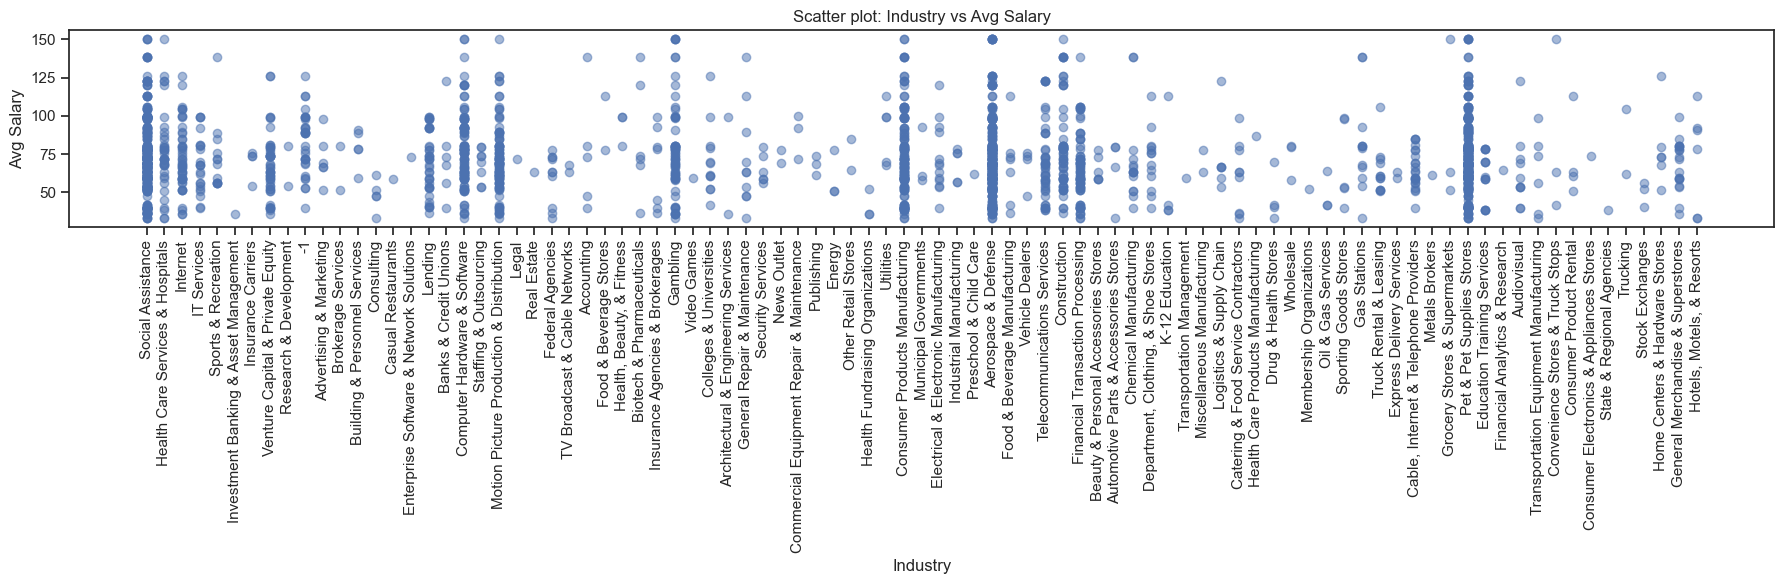

In [409]:
plt.figure(figsize=(18, 6))

# Codificar sectores numéricamente solo para poder graficar
df["Industry_code"] = df["Industry"].astype("category").cat.codes

plt.scatter(df["Industry_code"], df["avg_salary"], alpha=0.5)

plt.xticks(
    ticks=range(len(df["Industry"].unique())), 
    labels=df["Industry"].unique(), 
    rotation=90
)

plt.title("Scatter plot: Industry vs Avg Salary")
plt.xlabel("Industry")
plt.ylabel("Avg Salary")
plt.tight_layout()
plt.show()



In [410]:
p_val, r2_val = anova_r2(df, "Industry")
print(f"P-value: {p_val}")
print(f"R²: {r2_val:.4f}")


P-value: 0.07675962577627105
R²: 0.0480


En aquest cas veiem que no tenim un p-value estadísticament significatiu i una R^2 poc explicativa. No obstant això es podria deure a que tenim moltes categories d'industry i aquestes tenen poques mostres. Agruparem primer per categories i després recalcularem per si cal eliminar la variable. 

In [411]:
counts = df['Industry'].value_counts().head(50) # tail(50)

# Mostrar les categories i la seva quantitat
print(counts)

Industry
-1                                           353
IT Services                                  325
Staffing & Outsourcing                       322
Health Care Services & Hospitals             151
Computer Hardware & Software                 111
Consulting                                   111
Investment Banking & Asset Management         78
Enterprise Software & Network Solutions       69
Internet                                      65
Advertising & Marketing                       51
Banks & Credit Unions                         51
Insurance Carriers                            47
Colleges & Universities                       40
Accounting                                    39
Biotech & Pharmaceuticals                     33
Social Assistance                             23
Aerospace & Defense                           22
Video Games                                   20
Lending                                       15
State & Regional Agencies                     15
Architectur

In [412]:
def map_industry(industry):
    if industry in ['IT Services', 'Computer Hardware & Software', 'Enterprise Software & Network Solutions', 'Internet', 'Telecommunications Services', 'Venture Capital & Private Equity']:
        return 'IT & Software'
    elif industry in ['Consulting', 'Investment Banking & Asset Management', 'Financial Transaction Processing', 'Brokerage Services', 'Financial Analytics & Research', 'Banks & Credit Unions', 'Insurance Carriers', 'Insurance Agencies & Brokerages', 'Stock Exchanges']:
        return 'Consulting & Finance'
    elif industry in ['Health Care Services & Hospitals', 'Biotech & Pharmaceuticals', 'Health Care Products Manufacturing', 'Health, Beauty, & Fitness', 'Social Assistance', 'Health Fundraising Organizations']:
        return 'Health & Pharma'
    elif industry in ['Colleges & Universities', 'K-12 Education', 'Education Training Services', 'Preschool & Child Care']:
        return 'Education'
    elif industry in ['Industrial Manufacturing', 'Electrical & Electronic Manufacturing', 'Consumer Products Manufacturing', 'Miscellaneous Manufacturing', 'Chemical Manufacturing', 'Food & Beverage Manufacturing', 'Transportation Equipment Manufacturing']:
        return 'Manufacturing & Industrial'
    elif industry in ['Consumer Electronics & Appliances Stores', 'Department, Clothing, & Shoe Stores', 'Grocery Stores & Supermarkets', 'Food & Beverage Stores', 'Convenience Stores & Truck Stops', 'Vehicle Dealers', 'Pet & Pet Supplies Stores', 'Sporting Goods Stores', 'Home Centers & Hardware Stores', 'Other Retail Stores', 'Casual Restaurants', 'Cable, Internet & Telephone Providers']:
        return 'Retail & Consumer'
    elif industry in ['Architectural & Engineering Services', 'Construction', 'Commercial Equipment Repair & Maintenance', 'Building & Personnel Services', 'Logistics & Supply Chain']:
        return 'Construction & Engineering'
    elif industry in ['Advertising & Marketing', 'TV Broadcast & Cable Networks', 'Publishing', 'News Outlet', 'Motion Picture Production & Distribution', 'Audiovisual', 'Catering & Food Service Contractors']:
        return 'Media & Marketing'
    elif industry in ['Federal Agencies', 'State & Regional Agencies', 'Municipal Governments']:
        return 'Government & Public'
    elif industry in ['Energy', 'Oil & Gas Services', 'Utilities']:
        return 'Energy & Utilities'
    elif industry in ['Trucking', 'Transportation Management', 'Express Delivery Services', 'Truck Rental & Leasing']:
        return 'Transportation'
    else:
        return 'Other / Miscellaneous'


df['Industry_Group'] = df['Industry'].apply(map_industry)


print(df['Industry_Group'].value_counts())


Industry_Group
Other / Miscellaneous         836
IT & Software                 582
Consulting & Finance          310
Health & Pharma               228
Media & Marketing              75
Education                      52
Construction & Engineering     42
Retail & Consumer              36
Government & Public            36
Manufacturing & Industrial     35
Energy & Utilities             13
Transportation                  7
Name: count, dtype: int64


(0.0, 200.0)

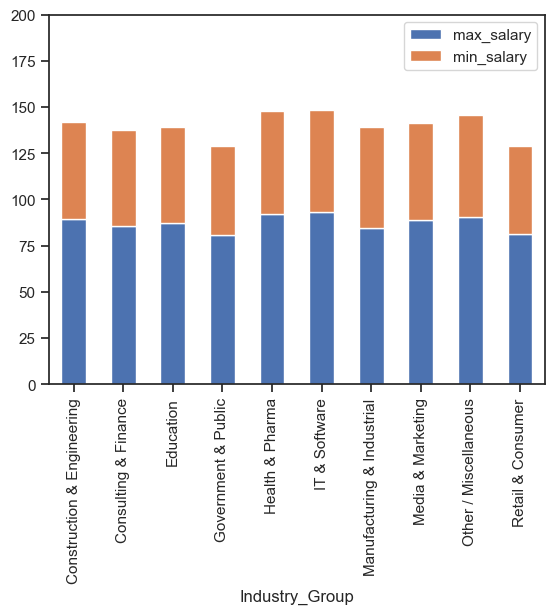

In [413]:
industry_freq = df['Industry_Group'].value_counts()

df[['max_salary', 'min_salary', 'Industry_Group']].\
    where(df['Industry_Group'].isin(industry_freq.iloc[:10].index)).\
    groupby('Industry_Group').mean().reset_index().plot.bar(x='Industry_Group', stacked=True)
plt.ylim(0,200)

In [414]:
p_val, r2_val = anova_r2(df, "Industry_Group")
print(f"P-value: {p_val}")
print(f"R²: {r2_val:.4f}")


P-value: 0.014890753492323562
R²: 0.0104


El sector té un efecte estadísticament significatiu sobre el salari però  és poc rellevant, perquè la quantitat de variància explicada és molt baixa (1.04%).

Per tant, és probable que incloure el sector no milloraria gaire el model i augmentaria molt la dimensionalitat del problema.


Per acabar, abans de concloure en la seva eliminació, agrupem les dues colunes estudiades per veure si combinades podrien ser prou explicaties com per mantenirles al model:

In [415]:
counts = df['Type of ownership'].value_counts().head(50) # tail(50)

# Mostrar les categories i la seva quantitat
print(counts)

Type of ownership
Company - Private                 1272
Company - Public                   452
-1                                 163
Nonprofit Organization             124
Subsidiary or Business Segment      89
Government                          37
College / University                34
Hospital                            19
Unknown                             16
Other Organization                  13
Contract                            11
School / School District             9
Private Practice / Firm              9
Self-employed                        2
Franchise                            2
Name: count, dtype: int64


In [416]:
# Simplificar Type of ownership
def map_ownership(x):
    if x in ["Company - Private"]:
        return "Private"
    elif x in ["Company - Public"]:
        return "Public"
    elif x in ["Government"]:
        return "Government"
    elif x in ["Hospital", "School / School District", "Nonprofit Organization"]:
        return "Public/Nonprofit"
    elif x in ["College / University"]:
        return "University"
    else:
        return "Other"

df['Ownership_Group'] = df['Type of ownership'].apply(map_ownership)

# Exemple combinant amb Industry_Group
df['Industry_Ownership'] = df['Industry_Group'] + " | " + df['Ownership_Group']


counts = df['Industry_Ownership'].value_counts().head(50) # tail(50)

# Mostrar les categories i la seva quantitat
print(counts)

Industry_Ownership
Other / Miscellaneous | Private             452
IT & Software | Private                     446
Other / Miscellaneous | Other               235
Consulting & Finance | Private              152
Other / Miscellaneous | Public              132
Consulting & Finance | Public               115
IT & Software | Public                      114
Health & Pharma | Public/Nonprofit           99
Health & Pharma | Private                    77
Media & Marketing | Private                  46
Health & Pharma | Public                     32
Construction & Engineering | Private         32
Education | University                       32
Government & Public | Government             29
Consulting & Finance | Public/Nonprofit      25
Retail & Consumer | Private                  23
IT & Software | Other                        21
Media & Marketing | Public                   21
Manufacturing & Industrial | Private         18
Consulting & Finance | Other                 16
Other / Miscellaneous

(0.0, 180.0)

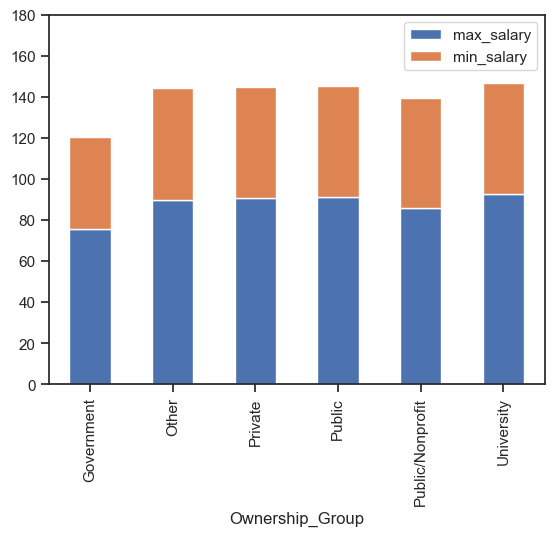

In [417]:
ownership_freq = df['Ownership_Group'].value_counts()

df[['max_salary', 'min_salary', 'Ownership_Group']].\
    where(df['Ownership_Group'].isin(ownership_freq.iloc[:6].index)).\
    groupby('Ownership_Group').mean().reset_index().plot.bar(x='Ownership_Group', stacked=True)

plt.ylim(0,180)

Veiem que no existeixen diferències notòries en aquesta variable així que a continuació farem un estudi de si eliminar-la o combinar-la amb una altra. 

In [418]:
# Map Industry a grups més grans
def map_industry_simple(x):
    if x in ["IT & Software", "Consulting & Finance"]:
        return "Tech_Finance"
    elif x in ["Health & Pharma", "Education", "Government & Public"]:
        return "Health_Education"
    elif x in ["Media & Marketing", "Retail & Consumer"]:
        return "Media_Retail"
    elif x in ["Manufacturing & Industrial", "Energy & Utilities", "Construction & Engineering", "Transportation"]:
        return "Industry_Energy_Construction"
    else:
        return "Other"

df['Industry_Simple'] = df['Industry_Group'].apply(map_industry_simple)

# Map Ownership a 3 grups
def map_ownership_simple(x):
    if x == "Private":
        return "Private"
    elif x == "Public/Nonprofit":
        return "Public/Nonprofit"
    else:
        return "Other"

df['Ownership_Simple'] = df['Ownership_Group'].apply(map_ownership_simple)

# Combinar
df['Industry_Ownership_Simple'] = df['Industry_Simple'] + " | " + df['Ownership_Simple']

# Veure resultats
print(df['Industry_Ownership_Simple'].value_counts())


Industry_Ownership_Simple
Tech_Finance | Private                    598
Other | Private                           452
Other | Other                             369
Tech_Finance | Other                      268
Health_Education | Other                  116
Health_Education | Public/Nonprofit       111
Health_Education | Private                 89
Media_Retail | Private                     69
Industry_Energy_Construction | Private     64
Media_Retail | Other                       42
Industry_Energy_Construction | Other       33
Tech_Finance | Public/Nonprofit            26
Other | Public/Nonprofit                   15
Name: count, dtype: int64


In [419]:
p_val, r2_val = anova_r2(df, "Industry_Ownership_Simple")
print(f"P-value: {p_val}")
print(f"R²: {r2_val:.4f}")


P-value: 0.15738598554616806
R²: 0.0075


Veiem com tot i la significació estadística de p-value = 0.035 < 0.05, només un 1% de la variança del salary prové d'aquesta variale pe tant té un impacte pràctic molt baix.

In [420]:
# Esborrem les columnes auxiliars de les gràfiques
df.drop(columns=["Industry_code", "Type of ownership code"], inplace=True)

Com a resum general, veiem per cada variable el valor del p-valor i el R2. A més, s'afegeix una columna per veure si cal mantenir o eliminar la variable

In [421]:
# Neteja de dades: eliminem files amb NaN en avg_salary
df_clean = df.dropna(subset=["avg_salary"]).copy()

cols = df_clean.columns.tolist()
cols.remove("avg_salary")
cols.remove("min_salary")
cols.remove("max_salary")

resultats = []

for col in cols:
    # Saltar si només té un valor únic
    if df_clean[col].nunique() <= 1:
        continue
    
    # Callem la funció anova_r2 creada anteriorment
    p_value, r2 = anova_r2(df_clean, col)
    
    if p_value is None or r2 is None:
        continue  # No podem fer ANOVA amb menys de 2 grups vàlids
    
    # Decisió d'eliminació
    if p_value >= 0.05 and r2 < 0.05:
        decision = "Eliminar"
    elif p_value >= 0.05 or r2 < 0.05:
        decision = "Valorar"
    else:
        decision = "Mantenir"
    
    resultats.append({
        "Variable": col,
        "P-value": p_value,
        "R²": r2,
        "Decisió": decision
    })

# Convertim els resultats a DataFrame i ordenem per R² descendent
resultats_df = pd.DataFrame(resultats).sort_values("R²", ascending=False)
print(resultats_df)


No hi ha suficients grups vàlids per fer ANOVA.
No hi ha suficients grups vàlids per fer ANOVA.
                     Variable        P-value        R²   Decisió
8                 Competitors   1.184404e-06  0.476587  Mantenir
3                    Location  4.917909e-160  0.437317  Mantenir
2                Company Name   1.925469e-08  0.429376  Mantenir
4                Headquarters   3.641601e-22  0.254139  Mantenir
0                   Job Title   3.799080e-02  0.190401  Mantenir
1                      Rating   3.444256e-15  0.112648  Mantenir
12                Company Age   3.256605e-05  0.085959  Mantenir
6                    Industry   7.675963e-02  0.048029  Eliminar
15         Industry_Ownership   6.283942e-02  0.022648  Eliminar
7                      Sector   1.159243e-02  0.020182   Valorar
13             Industry_Group   1.489075e-02  0.010427   Valorar
5           Type of ownership   4.667771e-02  0.009671   Valorar
18  Industry_Ownership_Simple   1.573860e-01  0.007457  Eli

Les variables que ens ha arribat a conclusio d'eliminar/valorar, això no vol dir necessàriament que no tinguin cap rellevància, sinó que per si soles, en un ANOVA simple, no expliquen gaire del salari. És possible que les variables tinguin interaccions amb altres variables així que abans d'eliminar-les les provarem en un model multivariable amb aquelles que val la pena valorar. 

In [422]:
df_model = df.copy()

# Variables a provar (les que ANOVA marca "Mantenir" o "Valorar")
vars_categoricals = [
    "Industry_Ownership_Simple", "Rating", "Sector", "Industry_Group", "Ownership_Group"
]

vars_continuous = [
    "Revenue mean", "Size mean", "Company Age", "Has_revenue_info"
]

# Omplim NaN per variables contínues (opcional: amb mitjana)
df_model[vars_continuous] = df_model[vars_continuous].fillna(df_model[vars_continuous].mean())

# Eliminem files amb NaN en variables categòriques
df_model = df_model.dropna(subset=vars_categoricals + ["avg_salary"])

X = df_model[vars_categoricals + vars_continuous]
y = df_model["avg_salary"]


In [423]:
# Preprocessament: One-hot per categòriques, StandardScaler per contínues
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), vars_categoricals),
        ('num', StandardScaler(), vars_continuous)
    ]
)

# Pipeline amb regressió lineal
#pipeline = Pipeline(steps=[
#    ('preprocessor', preprocessor),
#    ('regressor', LinearRegression())
#])

# Pipeline amb Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=500, random_state=42, n_jobs=-1
    ))
])

# Dividim train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [424]:

# Entrenar
pipeline.fit(X_train, y_train)

# Predir
y_pred = pipeline.predict(X_test)

# R² sobre test set
r2 = r2_score(y_test, y_pred)
print(f"R² multivariable: {r2:.4f}")


R² multivariable: -0.0310


Provant models multiavriables tant de regressió lineal com de random forest obtenim uns R2 negatius tal que aquests factors no aporten informació predictiva rellevant ni tant sols combinades. Per tant, eliminem les variables que segons ANOVA podiem eliminar.


In [425]:
df.drop(columns=["Industry", "Type of ownership", "Ownership_Simple", "Industry_Ownership", "Industry_Simple", "Revenue mean", "Size mean", "Has_revenue_info", "Industry_Ownership_Simple"], inplace=True)

Ara decidim sobre les variables que segons anova calia valorar. Teniem les seguents dades:
| Variable                  | P-value | R²    
| ------------------------- | ------- | ------
| Industry_Group            | 0.0148  | 0.0104
| Sector                    | 0.0115  | 0.0202
| Rating                    | 0.0282  | 0.0238

Tenim un R^2 molt baix, per tant tenim molt poca explicació de la variança del salari. Els p-values indiquen que les variables son estadisticament significatives però practicament sense efecte. Comparant amb altres variables com Competitors o Location el seu efecte es menor. No eliminem Industry_Group de moment perquè la farem servir més endevant.

Decidim mantenir Sector i Rating, ja que tenen efectes lleugerament més importants en quant al valor de R2.


In [426]:
ownership_dummies = pd.get_dummies(df['Ownership_Group'], prefix='Ownership_Group')

df = pd.concat([df, ownership_dummies], axis=1)

industry_dummies = pd.get_dummies(df['Industry_Group'], prefix='Industry_Group')

df = pd.concat([df, industry_dummies], axis=1)

**Conversio daltres variables categoriques**

Ara tenint només les variables que tenen una relació significant amb la variable objectiu, és el moment de convertir les variables categòriques amb one-hot-encoding per poder entrenar correctament el nostre model.

Variable Job Title

In [427]:
# Nombre de valors únics
num_unics = df['Job Title'].nunique()
print("Nombre de valors únics a Job Title:", num_unics)

# Nombre de valors totals
num_totals = df['Job Title'].shape[0]

# Nombre de valors repetits
num_repetits = num_totals - num_unics
print("Nombre de valors repetits a Job Title:", num_repetits)

Nombre de valors únics a Job Title: 1271
Nombre de valors repetits a Job Title: 981


Hi ha massa valors unics per fer one-hot-encoding, aixi que agruparem primer per categories i despres assignarem. Usant el wordcloud vist a l'apartat EDA prenem:

In [428]:
def clean_title(title):
    title = title.lower()
    title = re.sub(r'[^a-z0-9\s]', '', title)  # eliminar símbols
    title = re.sub(r'\s+', ' ', title).strip()
    return title

df['clean_title'] = df['Job Title'].apply(clean_title)

In [429]:
def extract_seniority(title):
    t = title.lower()
    
    if any(x in t for x in ["director", "manegement", "head", "vp", "manager", "lead", " iv", "iv "]) \
        or re.search(r'\bIV\b', title): 
        return "manager"
    
    elif any(x in t for x in ["senior", "sr ", "principal", "iii", "specialist"]):       
        return "senior"
    
    elif any(x in t for x in ["ii"]):
        return "mid"
    
    elif any(x in t for x in ["junior", "jr ", "entry level", "intern", "summer", "associate"]) \
        or re.search(r'\bI\b', title):        
        return "junior"
    
    else:
        return "mid"

df["Seniority"] = df["Job Title"].apply(extract_seniority)

df["Seniority"].value_counts()


Seniority
mid        1655
senior      371
junior      121
manager     105
Name: count, dtype: int64

De la variable Job Title extreurem dues coses, per una banda la senioritat, és a dir, el nivell del lloc de trabll, si es junior, mitjà, senior o manager. Per una altra banda, extraiem el tipus de treball, si serà fer reporting, programar, data analyst general...

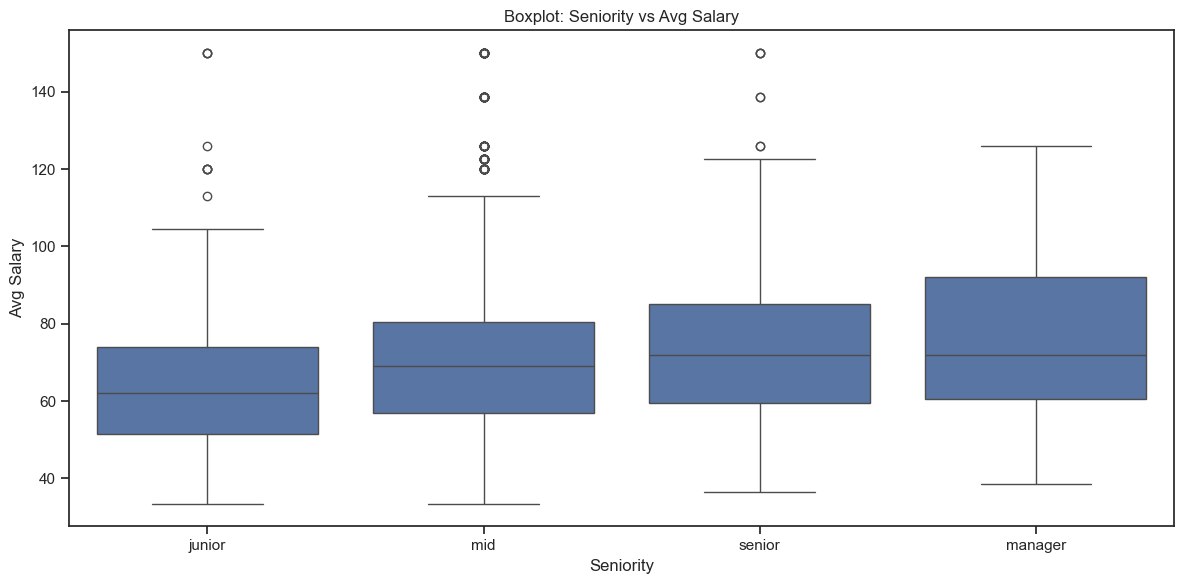

In [430]:
seniority_order = ["junior", "mid", "senior", "manager"]
df["Seniority"] = pd.Categorical(df["Seniority"], categories=seniority_order, ordered=True)

plt.figure(figsize=(12, 6))
sns.boxplot(x="Seniority", y="avg_salary", data=df, order=seniority_order)

plt.title("Boxplot: Seniority vs Avg Salary")
plt.xlabel("Seniority")
plt.ylabel("Avg Salary")
plt.tight_layout()
plt.show()


A primera vista es veu que sí que hi ha diferència del sou entre els diferents nivells dins s'una empresa, per tant resulta útil aquesta transformació.

Hem decidit assignar valors numèrics a la categoria de seniority per tal de poder utilitzar-la de manera directa en models de predicció de salaris i en visualitzacions. 

La codificació estableix 0 per a “junior”, 1 per a “mid”, 2 per a “senior” i 3 per a “manager”, reflectint de manera ordinal el nivell de responsabilitat dins de l’empresa. Resulta coherent fer aquesta asignació perquè hi ha un ordre intrínsec als nivells dins d'una empresa.

In [431]:
seniority_mapping = {"junior": 0, "mid": 1, "senior": 2, "manager": 3}
df["Seniority_code"] = df["Seniority"].map(seniority_mapping)


Els nivells més alts de seniority solen associar-se amb salaris més elevats, com es veu a les mitjanes de cada categoria (junior, mid, senior, manager).


In [432]:

def extract_role(title):
    t = title.lower()
    
    # rols especifics
    if re.search(r'\bdata scientist\b', t) or re.search(r'\bdata engineer\b', t) or "developer" in t:
        return "data_scientist"
    if re.search(r'\bdata warehouse\b', t) or "etl" in t or "integration" in t:
        return "data_warehouse"
    
    # rols de negoci
    if "financial" in t or "pricing" in t or "accounting" in t or "revenue" in t or "financial" in t:
        return "financial_analyst"
    if "marketing" in t or "product" in t:
        return "marketing_analyst"
    if "business analyst" in t:
        return "business_analyst"
    
    # rols especialitzats
    if "quality" in t:
        return "data_quality"
    if "governance" in t or "steward" in t or "lineage" in t:
        return "data_governance"
    if "report" in t or "visualization" in t:
        return "data_reporting"
    if "management analyst" in t or "management" in t:
        return "data_management"
    if "health" in t or "clinical" in t or "patient" in t or "epidemiology" in t or "healthcare" in t:
        return "healthcare_analyst"
    if "security" in t or "risk" in t or "protection" in t:
        return "security_analyst"
    if "sql" in t:
        return "sql_analyst"
    
    # rols generals
    if "data analyst" in t:
        return "data_analyst"
    
    # altres
    return "other"

df["Role"] = df["Job Title"].apply(extract_role)

df["Role"].value_counts()


Role
data_analyst          1365
other                  228
healthcare_analyst      80
data_reporting          77
marketing_analyst       71
financial_analyst       64
business_analyst        63
security_analyst        54
data_scientist          53
data_governance         47
data_warehouse          46
data_quality            45
data_management         39
sql_analyst             20
Name: count, dtype: int64

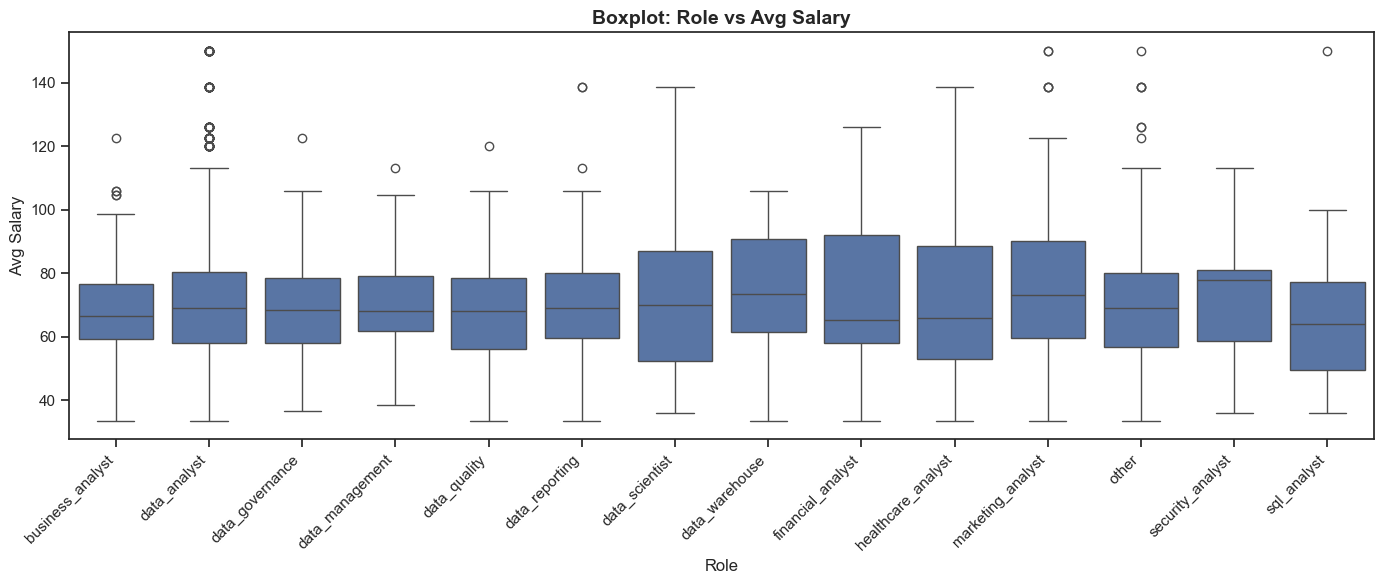

In [433]:
plt.figure(figsize=(14, 6))
role_order = sorted(df['Role'].unique())
sns.boxplot(x='Role', y='avg_salary', data=df, order=role_order)

plt.title('Boxplot: Role vs Avg Salary', fontsize=14, fontweight='bold')
plt.xlabel('Role', fontsize=12)
plt.ylabel('Avg Salary', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Veiem com es presenten certes diferències entre el salary mig de cada tipus de feina.
A continuació codificarem la variable rols fent target encoding:

In [434]:
role_dummies = pd.get_dummies(df["Role"], prefix="Role")
df = pd.concat([df, role_dummies], axis=1)


In [435]:
df = df.drop(columns=["Job Title", "Seniority", "clean_title", "Role"])

**Variable Job Description**

Per la variable job description, fem servir la llibreria stopwords de nltk. Ens permet transformar el text de les descripcions de feina en informació quantificable. L’objectiu final és extreure patrons, paraules clau o continguts recurrents que ens ajudin a crear noves variables útils per a l’anàlisi i per millorar els models predictius basats en les ofertes de treball.

In [436]:
# Llista de "stop words" en angles
stop_words = stopwords.words('english')

# Funció per netejar el text
def clean_text(text):
    text = text.lower()  # Convertir a minúscules
    text = re.sub(r'\d+', '', text)  # Eliminar nombres
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signes de puntuació
    return text

# Aplicar neteja a les descripcions
df['cleaned_description'] = df['Job Description'].apply(clean_text)

# Vectorització del text
vectorizer = CountVectorizer(stop_words=stop_words, max_features=20)
X = vectorizer.fit_transform(df['cleaned_description'])

# Obtenir les paraules més freqüents
frequent_words = vectorizer.get_feature_names_out()

print(frequent_words)


['ability' 'analysis' 'analyst' 'analytics' 'business' 'data' 'experience'
 'information' 'job' 'knowledge' 'management' 'reporting' 'required'
 'requirements' 'skills' 'strong' 'support' 'team' 'work' 'years']


Veiem com algunes d'aquestes paraules més freqüents són molt generals d'una descripció de feina i segurament no tenen rellevància a l'hora de predir el sou així que anem a fer una selecció de quines paraules són clau per la predicció. 

In [437]:
# Crear columnes booleanes per cada paraula
for word in frequent_words:
    df[f'word_{word}'] = df['cleaned_description'].apply(lambda x: 1 if word in x else 0)

# ANOVA de cada paraula amb el salari
anova_results = []
for word in frequent_words:
    group_0 = df.loc[df[f'word_{word}'] == 0, 'avg_salary']
    group_1 = df.loc[df[f'word_{word}'] == 1, 'avg_salary']
    
    # Calculem ANOVA només si ambdós grups tenen almenys 2 observacions
    if len(group_0) >= 2 and len(group_1) >= 2:
        f_stat, p_value = stats.f_oneway(group_0, group_1)
        anova_results.append({'word': word, 'p_value': p_value})

anova_df = pd.DataFrame(anova_results).sort_values('p_value')
print(anova_df)

for word in frequent_words:
    df = df.drop(columns=[f"word_{word}"])



            word   p_value
13  requirements  0.000013
17          team  0.002078
11     reporting  0.002407
7    information  0.004079
10    management  0.004839
14        skills  0.042341
9      knowledge  0.061919
2        analyst  0.090320
1       analysis  0.119710
4       business  0.218445
0        ability  0.238470
5           data  0.422544
16       support  0.528398
8            job  0.535046
6     experience  0.609045
15        strong  0.765563
3      analytics  0.788342
18          work  0.872778
19         years  0.903157
12      required  0.958310


In [438]:
best_words = ['requirements', 'team', 'reporting', 'information', 'management', 'skills']

# Crear columnes booleanes per cada paraula clau
for word in best_words:
    df[f'contains_{word}'] = df['cleaned_description'].apply(lambda x: 1 if word in x else 0)

df.drop(columns=['cleaned_description'], inplace=True)

Variable Company Name

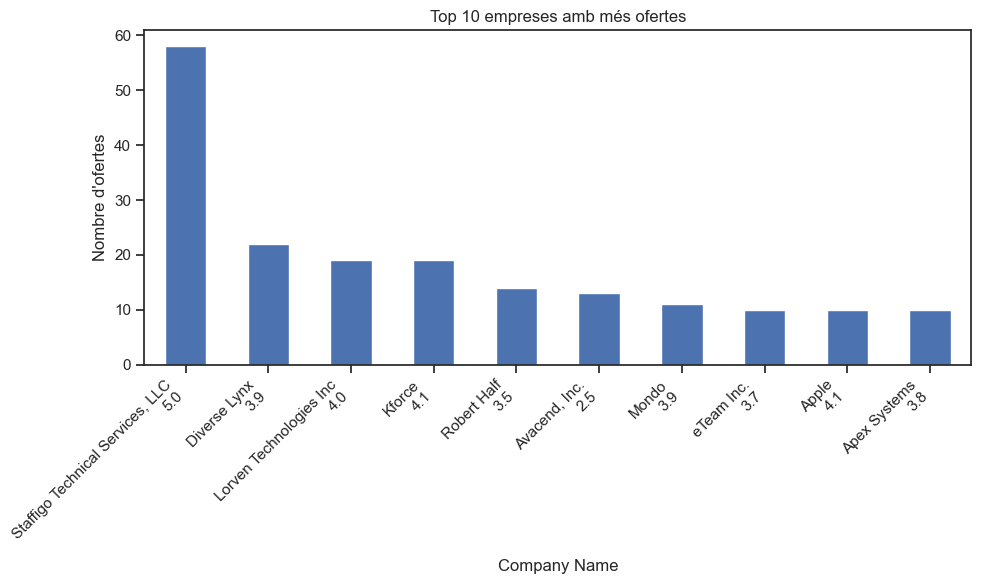

In [439]:
# Comptar ofertes per empresa
top_companies = df['Company Name'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_companies.plot(kind='bar')
plt.title("Top 10 empreses amb més ofertes")
plt.xlabel("Company Name")
plt.ylabel("Nombre d'ofertes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [440]:
# Comptar les ocurrències de cada empresa
company_counts = df['Company Name'].value_counts()

# Filtrar les empreses que apareixen només un cop
companies_one_time = company_counts[company_counts == 1]

# Comptar quantes empreses apareixen només un cop
num_companies_one_time = len(companies_one_time)

# Mostrar el resultat
print(f"Hi ha {num_companies_one_time} empreses que apareixen un únic cop.")

# Mostrar els resultats
print(company_counts)


Hi ha 1174 empreses que apareixen un únic cop.
Company Name
Staffigo Technical Services, LLC\n5.0    58
Diverse Lynx\n3.9                        22
Lorven Technologies Inc\n4.0             19
Kforce\n4.1                              19
Robert Half\n3.5                         14
                                         ..
PROLIM Global Corporation\n3.3            1
Xcel Energy\n3.5                          1
CitiusTech\n3.6                           1
MIRACORP\n4.8                             1
Edison Software, Inc.\n5.0                1
Name: count, Length: 1513, dtype: int64


In [441]:
# tractem el nan
df['Company Name'] = df['Company Name'].fillna(df['Location'] + "Company")

El Company name es un string que com a tal no podem aprofitar per fer una codificació ja que hi ha moltes empreses amb una única entrada i no es troben patrons repetits que puguem usar per codificar i que no estiguin ja recollits en alguna altra ariable com sector. No obstant, com que hi ha empreses que tenen vàries entrades a la base de dades el que farem serà afegir una columna que compti el número d'ofertes d'aquella empresa. En general, una empresa amb moltes ofertes implicarà que és una empresa gran o que vol expandir el departament d'analisi de dades. 

In [442]:
df['Company Offers'] = df.groupby('Company Name')['Company Name'].transform('count')

**Competitors**:

Hem vist que és una variable categòrica de les que té més nuls. Imputar els seus valors no té sentit per un altre variable que no sigui  Unknown a més tenim molts valors 


In [443]:
# Comptar nombre d’entrades per cada categoria
counts = df['Competitors'].value_counts()
print("Nombre d’entrades per cada categoria:")
counts.head(50)


Nombre d’entrades per cada categoria:


Competitors
-1                                                                                           1731
Adecco, Manpower                                                                               14
Robert Half, Insight Global                                                                    14
Google, Microsoft, Samsung Electronics                                                         10
Artech Information Systems, Mindlance, Tech Mahindra                                           10
TEKsystems, Insight Global, Accenture                                                          10
Adecco, Kforce                                                                                  9
State Street, Northern Trust, BlackRock                                                         9
Accenture, CGI, Sopra Steria                                                                    7
Kforce, Insight Global, Volt Consulting Group                                                   7
Capgemin

In [444]:
# Comptar quantes categories tenen només 1 entrada
unique_count = (counts == 1).sum()
print(f"\nNombre de categories amb només 1 entrada: {unique_count}")


Nombre de categories amb només 1 entrada: 193


In [445]:
# creem una variable que sigui el numero de competidors per quantificar el model
df['num_competitors'] = df['Competitors'].apply(
    lambda x: 0 if x == '-1' else len(x.split(','))
)

**Location**

In [446]:
num_locations = df['Location'].nunique()
print(f"Nombre de locations diferents: {num_locations}")


location_counts = df['Location'].value_counts()
print("\nNombre d’entrades per location:")
print(location_counts.head(60))

Nombre de locations diferents: 253

Nombre d’entrades per location:
Location
New York, NY                       310
Chicago, IL                        130
San Francisco, CA                  119
Austin, TX                          81
Los Angeles, CA                     80
Charlotte, NC                       78
Houston, TX                         72
Dallas, TX                          66
San Diego, CA                       62
Philadelphia, PA                    56
Denver, CO                          47
San Antonio, TX                     45
San Jose, CA                        38
Phoenix, AZ                         35
Jersey City, NJ                     33
Tempe, AZ                           31
Seattle, WA                         30
Irving, TX                          29
Columbus, OH                        29
Plano, TX                           28
Santa Clara, CA                     22
Salt Lake City, UT                  22
Jacksonville, FL                    19
El Segundo, CA            

La localització amb més ofertes és la ciutat de Nova York (cosa que té sentit amb la gran oferta que té la ciutat)

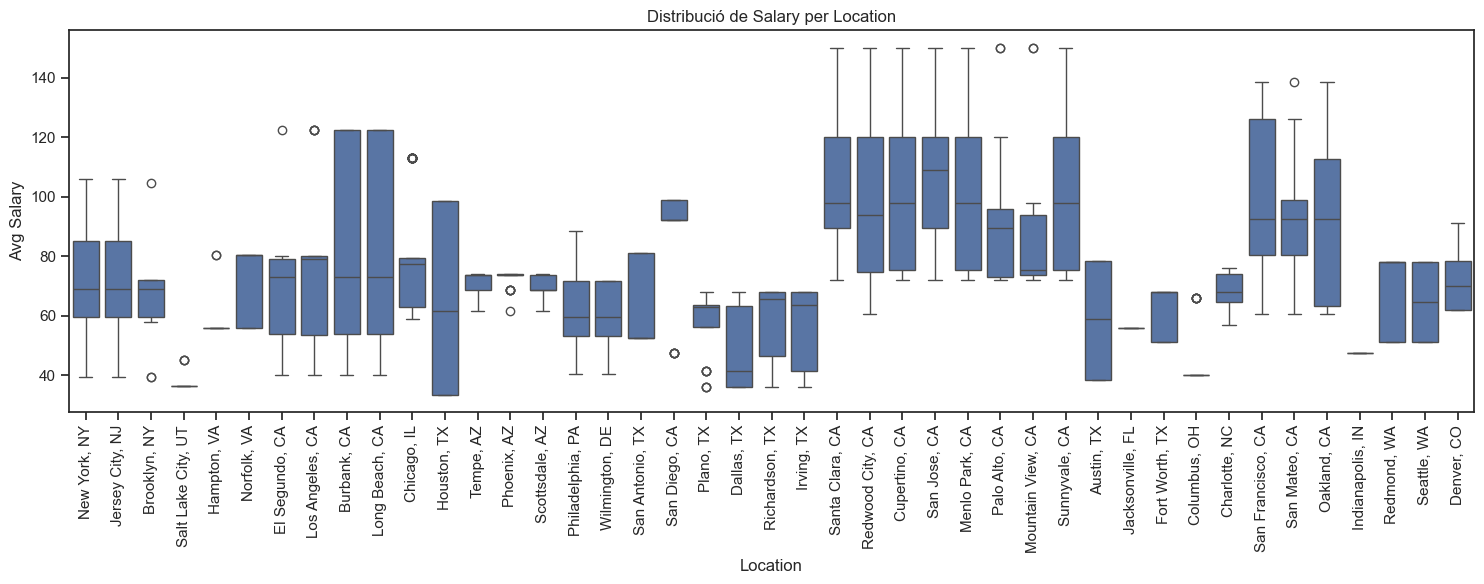

In [447]:
min_entries = 10
top_locations = location_counts[location_counts >= min_entries].index

plt.figure(figsize=(15,6))
sns.boxplot(x='Location', y='avg_salary', data=df[df['Location'].isin(top_locations)])
plt.xticks(rotation=90)
plt.title('Distribució de Salary per Location')
plt.ylabel('Avg Salary')
plt.xlabel('Location')
plt.tight_layout()
plt.show()

In [448]:
# Extreure l’estat
df['State'] = df['Location'].str.split(',').str[-1].str.strip()
df['City'] = df['Location'].str.split(',').str[0].str.strip()

# Llista d’estats únics
states = df['State'].dropna().unique()

# Guardarem els resultats
anova_results = []

for state in states:
    df_state = df[df['State'] == state]
    
    # Comprovem quantes ciutats hi ha i quantes observacions té cada una
    city_counts = df_state['Location'].value_counts()
    cities = city_counts[city_counts >= 2].index  # Només ciutats amb almenys 2 observacions
    
    if len(cities) < 2:
        continue  # No podem fer ANOVA amb menys de 2 grups
    
    # Crear grups per ANOVA
    groups = [df_state[df_state['Location'] == city]['avg_salary'] for city in cities]
    
    # ANOVA
    f_stat, p_value = stats.f_oneway(*groups)
    
    anova_results.append({
        'State': state,
        'Num_cities': len(cities),
        'Num_obs': len(df_state),
        'P_value': p_value
    })

anova_df = pd.DataFrame(anova_results).sort_values('P_value')

print(anova_df)


   State  Num_cities  Num_obs       P_value
5     FL           2       27  0.000000e+00
3     CA          47      626  1.923992e-21
7     TX          19      394  7.479566e-04
14    CO           9       96  1.335651e-02
8     AZ           7       97  1.660674e-02
1     NJ          16       86  4.469605e-02
6     IL           8      164  7.723031e-02
4     VA           5       48  1.196688e-01
9     PA          12      114  1.658998e-01
10    OH           4       35  5.764219e-01
13    WA           7       53  6.102210e-01
0     NY           6      345  6.140702e-01
11    NC           3       90  6.288995e-01
2     UT           3       33  8.040515e-01
12    IN           2       23           NaN


c:\Users\sara\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\sara\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


Tot i ser nova york la ciutat amb més oferta, l'estat amb més oferta és Californa. Veiem ara la distribució del salari en els diferents estats:

<Axes: xlabel='State'>

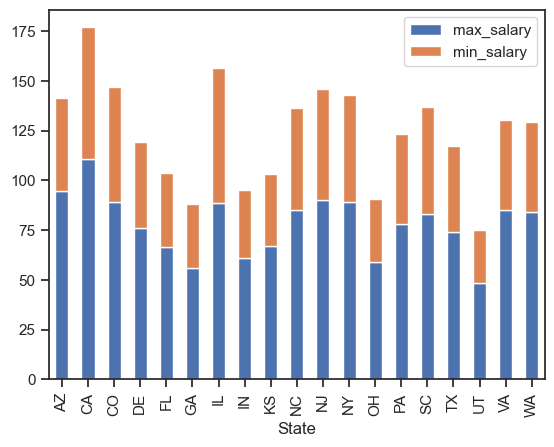

In [449]:
df[['max_salary', 'min_salary', 'State']].groupby('State').\
    mean().reset_index().plot.bar(x='State', stacked=True)

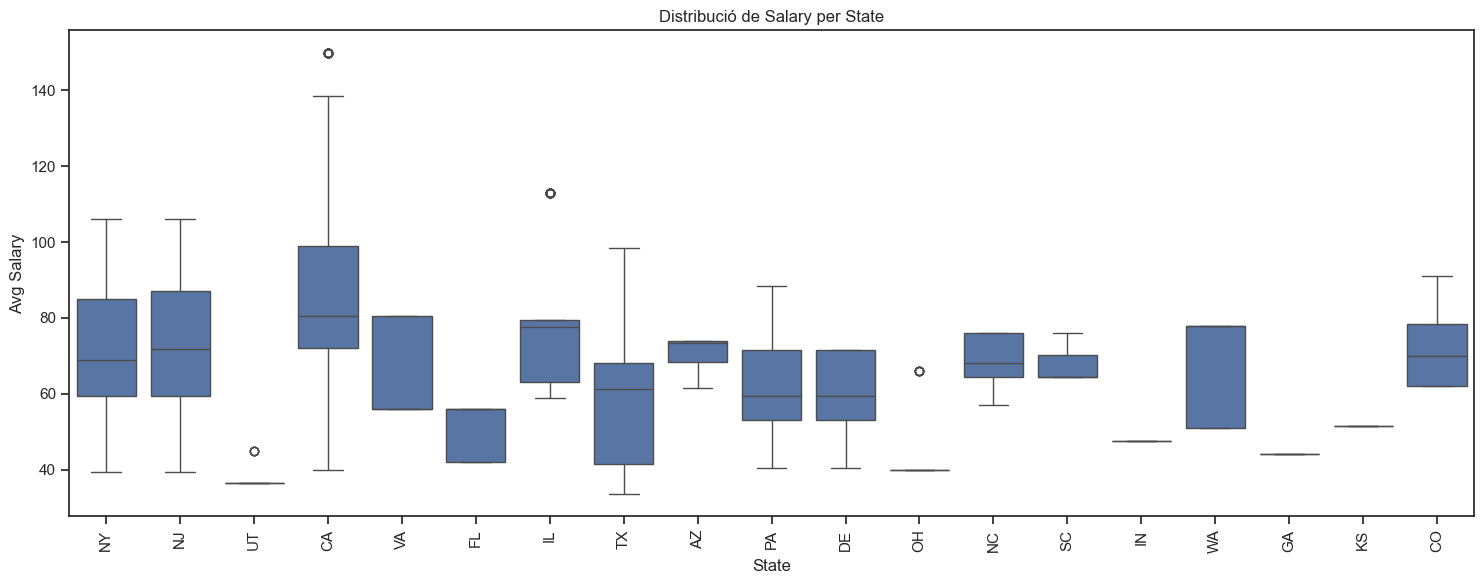

In [450]:
plt.figure(figsize=(15,6))
sns.boxplot(x='State', y='avg_salary', data=df)
plt.xticks(rotation=90)
plt.title('Distribució de Salary per State')
plt.ylabel('Avg Salary')
plt.xlabel('State')
plt.tight_layout()
plt.show()

California sembla estar no uniformement ditrubuida comparat amb la resta d'estats. Sent Silicon Valley la ciutat amb més ofertes de California, significa que hi ha una gran diferència de salari entre aquesta ciutats i les altres de l'estat. 
A més amb els plots podem concloure que clarament en termes de salary California és l'estat més fort. 

Texas es troba en una situació similar pel que fa a les seves desigualtats salarials

Veiem que per una mateixa ciutat es poden tenir mitjanes salarials molt diferent per tant agrupar per estat i fer nomes certes distincions de ciutats per alguns estats no ajuda gaire a predir el model. Per tant, agruparem la localització per estat i a  mes per ciutats sempre i quan tinguin certa representacio en el dataset.

In [451]:
var = 0.01   # 1% del dataset
state_index = df['State'].value_counts().\
    where(df['State'].value_counts() / df.shape[0] > var, np.nan).dropna().index

state_dummies = pd.get_dummies(
    df['State'].where(df['State'].isin(state_index)),
    prefix='state'
)

city_index = df['City'].value_counts().\
    where(df['City'].value_counts() / df.shape[0] > var, np.nan).dropna().index

city_dummies = pd.get_dummies(
    df['City'].where(df['City'].isin(city_index)),
    prefix='city'
)

df = pd.concat([df, state_dummies], axis=1)
df = pd.concat([df, city_dummies], axis=1)


**Headquarters**

In [452]:
# headquarters -> molta correlacio amb location aixi que mirem de distribuir des daqui.
coincidencia = (df['Location'] == df['Headquarters']).sum()
print("Coincidències Headquarters i Location:", coincidencia)

# Filtrar files on Headquarters i Location són diferents (i Headquarters no és NaN)
diff_hq_location = df[(df['Headquarters'] != '-1') & (df['Headquarters'] != df['Location'])]

# Guardar en una variable
comparativa_diff = diff_hq_location[['Headquarters', 'Location', 'Company Name']]

comparativa_diff

Coincidències Headquarters i Location: 651


,Headquarters,Location,Company Name
3,"McLean, VA","New York, NY",Celerity\n4.1
5,"Stamford, CT","New York, NY",Point72\n3.9
8,"London, United Kingdom","New York, NY",DMGT\n4.0
12,"Bronx, NY","New York, NY",Montefiore Medical\n3.7
14,"Phoenix, AZ","Jersey City, NJ",Advisor Group\n3.4
...,...,...,...
2243,"Alpharetta, GA","Denver, CO","Avacend, Inc.\n2.5"
2244,"Ashburn, VA","Centennial, CO",Forfeiture Support Associates\n2.8
2246,"Newark, CA","Broomfield, CO",APN Software Services Inc.\n4.1
2247,"Alpharetta, GA","Denver, CO","Avacend, Inc.\n2.5"


Hi ha 650 files on coincideix el Headquarter i la Location pero hi ha 2251 files (no nules) on no coincideix (segurament per varies seus), mirem si es pot a partir del company name veure quines empreses tenen una sola seu i substituir aquelles

In [453]:
# Reemplaçar -1 per NaN
df['Headquarters'] = df['Headquarters'].replace('-1', pd.NA)

# Comptar quants Headquarters únics té cada companyia
hq_counts = df.groupby('Company Name')['Headquarters'].nunique(dropna=True).reset_index()
hq_counts.rename(columns={'Headquarters': 'hq_unique_count'}, inplace=True)

# Filtrar companyies amb un únic Headquarters conegut
companyies_segures = hq_counts[hq_counts['hq_unique_count'] == 1]['Company Name']
# Crear un diccionari Company Name -> Headquarters únic
hq_dict = df[df['Company Name'].isin(companyies_segures)].groupby('Company Name')['Headquarters'].first().to_dict()
# Imputar només les files segures amb Headquarters nul
df['Headquarters'] = df.apply(
    lambda row: hq_dict[row['Company Name']] if pd.isna(row['Headquarters']) and row['Company Name'] in hq_dict else row['Headquarters'],
    axis=1
)

# Comprovar quants nuls queden després de la imputació
print("Nuls a Headquarters després de la imputació:", df['Headquarters'].isna().sum())

Nuls a Headquarters després de la imputació: 171


Tenint en compte que la Location hem acabat agrupant-la segons el estat potser veiem que els headquarters no canvien gaire d'estat a la localització i podem atribuir-li al headquarter el valor del estat.

In [454]:
df['StateHeadquarters']= df['Headquarters'].str.split(',').str[-1].str.strip()

# Comptar coincidències d'estat entre Location i Headquarters
coincidencies_estat = (df['State'] == df['StateHeadquarters']).sum()
total_files = len(df)

print(f"Coincidències d'estat Location vs Headquarters: {coincidencies_estat} de {total_files} files")


Coincidències d'estat Location vs Headquarters: 948 de 2252 files


Veiem que hi ha mes coincidencies si només mirem el estat aixi que imputarem els nans per l'estat i codifiquem per lestat igual que hem fet a Location

In [455]:
# Substituir NaN o '-1' per l'estat de Location
df['StateHeadquarters'] = df['StateHeadquarters'].replace(['-1', ''], pd.NA)
df['StateHeadquarters'] = df['StateHeadquarters'].fillna(df['State'])


print(df['StateHeadquarters'].value_counts().head(50))

StateHeadquarters
CA                512
NY                278
TX                204
IL                175
NJ                172
VA                106
PA                 95
FL                 61
MI                 51
GA                 48
NC                 47
WA                 42
MD                 41
AZ                 38
CO                 35
OH                 35
United Kingdom     29
India              27
MA                 24
MO                 20
TN                 16
UT                 14
Japan              14
Canada             13
France             12
IN                 11
CT                  9
DC                  9
Singapore           7
Switzerland         7
SC                  7
MN                  6
AL                  5
WI                  5
Germany             5
DE                  4
Australia           4
RI                  4
PR                  4
KS                  4
IA                  4
OK                  4
Ireland             3
OR                  3
KY            

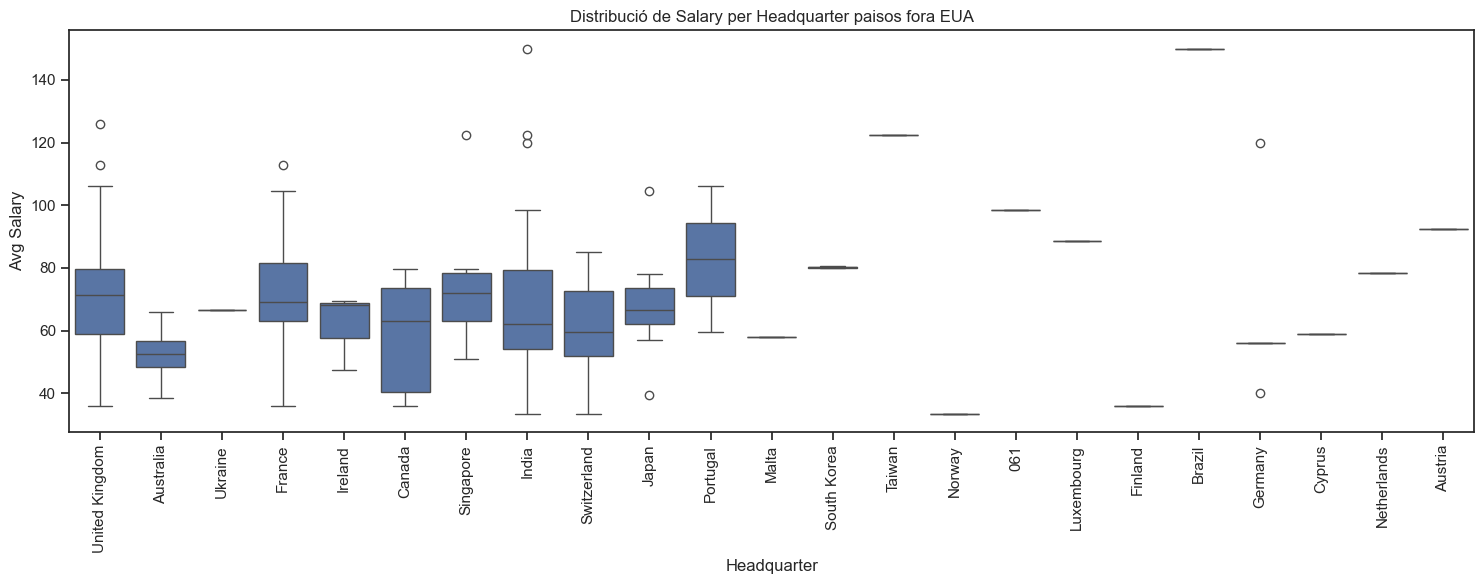

In [456]:
us_states = set([
    'AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN',
    'IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV',
    'NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN',
    'TX','UT','VT','VA','WA','WV','WI','WY','DC','PR'
])

df['IsForeign'] = ~df['StateHeadquarters'].isin(us_states)
df_foreign = df[df['IsForeign']]

plt.figure(figsize=(15,6))
sns.boxplot(x='StateHeadquarters', y='avg_salary', data=df_foreign)
plt.xticks(rotation=90)
plt.title('Distribució de Salary per Headquarter paisos fora EUA')
plt.ylabel('Avg Salary')
plt.xlabel('Headquarter')
plt.tight_layout()
plt.show()

In [457]:
quarters_dummies = pd.get_dummies(df['StateHeadquarters'], prefix='StateHeadquarters')
df = pd.concat([df, quarters_dummies], axis=1)


In [458]:
df.drop(columns=['StateHeadquarters'], inplace=True)

**Sector**

In [459]:
num_sectors = df['Sector'].nunique()
print(f"Nombre de sectors diferents: {num_sectors}")


sectors_counts = df['Sector'].value_counts()
print("\nNombre d’entrades per sector:")
print(sectors_counts.head(60))

Nombre de sectors diferents: 25

Nombre d’entrades per sector:
Sector
Information Technology                570
Business Services                     523
-1                                    353
Finance                               169
Health Care                           151
Education                              52
Insurance                              51
Accounting & Legal                     43
Media                                  42
Manufacturing                          40
Retail                                 38
Government                             36
Biotech & Pharmaceuticals              33
Non-Profit                             26
Aerospace & Defense                    22
Transportation & Logistics             20
Construction, Repair & Maintenance     16
Consumer Services                      14
Oil, Gas, Energy & Utilities           13
Real Estate                            12
Telecommunications                     11
Restaurants, Bars & Food Services       8
Arts, 

In [460]:
df['Sector'] = df['Sector'].replace('-1', np.nan)
print(df['Sector'].isna().sum())

353


In [461]:
mode_sector_by_industry = df.groupby('Industry_Group')['Sector'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# imputem segons industria
def fill_sector(row):
    if pd.isna(row['Sector']):
        return mode_sector_by_industry.get(row['Industry_Group'])
    return row['Sector']

df['Sector'] = df.apply(fill_sector, axis=1)

In [462]:
num_sectors = df['Sector'].nunique()
print(f"Nombre de sectors diferents: {num_sectors}")


sectors_counts = df['Sector'].value_counts()
print("\nNombre d’entrades per sector:")
print(sectors_counts.head(60))

Nombre de sectors diferents: 24

Nombre d’entrades per sector:
Sector
Business Services                     876
Information Technology                570
Finance                               169
Health Care                           151
Education                              52
Insurance                              51
Accounting & Legal                     43
Media                                  42
Manufacturing                          40
Retail                                 38
Government                             36
Biotech & Pharmaceuticals              33
Non-Profit                             26
Aerospace & Defense                    22
Transportation & Logistics             20
Construction, Repair & Maintenance     16
Consumer Services                      14
Oil, Gas, Energy & Utilities           13
Real Estate                            12
Telecommunications                     11
Restaurants, Bars & Food Services       8
Arts, Entertainment & Recreation        7
Mining

In [463]:
mapping = {
    'Restaurants, Bars & Food Services': 'Consumer Services',
    'Arts, Entertainment & Recreation': 'Media',
    'Mining & Metals': 'Manufacturing',
    'Travel & Tourism': 'Consumer Services'
}

df['Sector_Grouped'] = df['Sector'].replace(mapping)

In [464]:
sector_dummies = pd.get_dummies(df['Sector_Grouped'], prefix='Sector_Grouped')
df = pd.concat([df, sector_dummies], axis=1)

In [465]:
df.drop(columns=['Sector_Grouped'], inplace=True)

**EasyApply**

In [466]:
num_applies = df['Easy Apply'].nunique()
print(f"Nombre de applies diferents: {num_applies}")


appliesn_counts = df['Easy Apply'].value_counts()
print("\nNombre d’entrades per location:")
print(appliesn_counts.head(60))

Nombre de applies diferents: 2

Nombre d’entrades per location:
Easy Apply
-1      2172
True      80
Name: count, dtype: int64


In [467]:
# Convertim -1 a False
df['Easy_Apply'] = df['Easy Apply'].map({'True': 1, '-1': 0})

# Comprovem
df['Easy_Apply'].value_counts()

df.drop(columns=['Easy Apply'], inplace=True)

In [468]:
final_model = df.drop(columns=['Job Description', 'Company Name', 'Competitors', 'Location', 'State', 'Headquarters', 'Sector', 'Industry_Group','IsForeign', 'Ownership_Group', 'City'])
final_model

,Rating,min_salary,max_salary,avg_salary,Company Age,Ownership_Group_Government,Ownership_Group_Other,Ownership_Group_Private,Ownership_Group_Public,Ownership_Group_Public/Nonprofit,...,Sector_Grouped_Insurance,Sector_Grouped_Manufacturing,Sector_Grouped_Media,Sector_Grouped_Non-Profit,"Sector_Grouped_Oil, Gas, Energy & Utilities",Sector_Grouped_Real Estate,Sector_Grouped_Retail,Sector_Grouped_Telecommunications,Sector_Grouped_Transportation & Logistics,Easy_Apply
0,3.200000,37,66,51.5,64.0,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,1
1,3.800000,37,66,51.5,132.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,0
2,3.400000,37,66,51.5,22.0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,0
3,4.100000,37,66,51.5,23.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,3.900000,37,66,51.5,16.0,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,2.500000,78,104,91.0,17.0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,0
2248,2.900000,78,104,91.0,90.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,0
2249,3.452571,78,104,91.0,24.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2250,3.100000,78,104,91.0,41.0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,0


**Comprovació Nans**

In [469]:
missing = final_model.isna().sum() # Valors nuls normals

special_missing = (final_model == -1).sum() # Valors amb -1 considerats com a nuls
special_missing += (final_model== "-1").sum()
special_missing += (final_model == -1.0).sum()

total_missing = missing.add(special_missing, fill_value=0)
total_missing = total_missing[total_missing > 0]
total_missing

Series([], dtype: int64)

In [470]:
final_model.to_csv("data_preprocessed.csv", index=False)